## <center>**Práctica 2**</center>
### <center>**Clasificación de animales**</center>
#### <center>Procesamiento de Imagen, Vídeo y Audio</center>
#### <center>_Carlos Hermida Mayán_</center>

In [1]:
import skimage.io as io
from utils_animals import XGBModel, splitter, get_metrics, metrics_table, plot_all_cm, plot_animals
import numpy as np
from skimage.transform import resize
from skimage.color import gray2rgb, rgb2gray
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import feature, morphology
from skimage.filters import threshold_multiotsu

In [2]:
# plt.rcdefaults()
plt.rc('figure', facecolor=(0.16, 0.17, 0.2))
plt.rc('axes', facecolor=(0.16, 0.17, 0.2), edgecolor='white', labelcolor='white', titlecolor='white')
plt.rc('axes.spines', right=False, top=False)
plt.rc('xtick', color = 'white')
plt.rc('ytick', color = 'white')
plt.rc('legend', labelcolor = 'white')

In [3]:
SEED = 42
summary = dict()

Obtenemos las dimensiones másximas que pueden tomar las imágenes de las que disponemos.

In [4]:
max_rows = 0
max_cols = 0

for collection in ['elephant', 'emu', 'flamingo', 'rhino']:
    for image in io.imread_collection(f'objects/images/{collection}/*.jpg'):
        rows,cols = image.shape[:2]
        if rows > max_rows:
            max_rows = rows
        if cols > max_cols:
            max_cols = cols

print(f'Max rows: {max_rows}\nMax cols: {max_cols}')

Max rows: 300
Max cols: 300


Reescalamos las imágenes y máscaras al tamaño máximo y pasamos las imágenes en escala de gris a RGB, para que todas tengan el mismo formato.

Creamos el array de outputs codificado:
- Elephant -> 0
- Rhino -> 1
- Other -> 2

In [5]:
animal_names = ['elephant', 'emu', 'flamingo', 'rhino']
animal_codes = [0,2,2,1]

In [6]:
animals = []
labels = []
masks = []

for collection, code in zip(animal_names, animal_codes):
    
    for image in io.imread_collection(f'objects/images/{collection}/*.jpg'):
        if len(image.shape) == 2:
            image = gray2rgb(image)
        image = resize(image, (max_rows, max_cols))
        animals.append(image)
        labels.append(code)

    for mask in io.imread_collection(f'objects/masks/{collection}/*.png'):
        mask = resize(mask, (max_rows, max_cols))
        mask[mask > 0] = 1
        masks.append(mask.astype('bool'))

animals = np.array(animals)
masks = np.array(masks)
labels = np.array(labels)

print("Animals: ", animals.shape)
print("Masks: ", masks.shape)
print("Labels: ", labels.shape)

Animals:  (243, 300, 300, 3)
Masks:  (243, 300, 300)
Labels:  (243,)


### <center>**---> BASELINE <---**</center>

#### Preprocesado

Imágenes en escala de gris y aplanadas

##### Entrada

In [7]:
pre = rgb2gray(animals).reshape(243, -1)
print("Preprocessed Inputs -->", pre.shape)

Preprocessed Inputs --> (243, 90000)


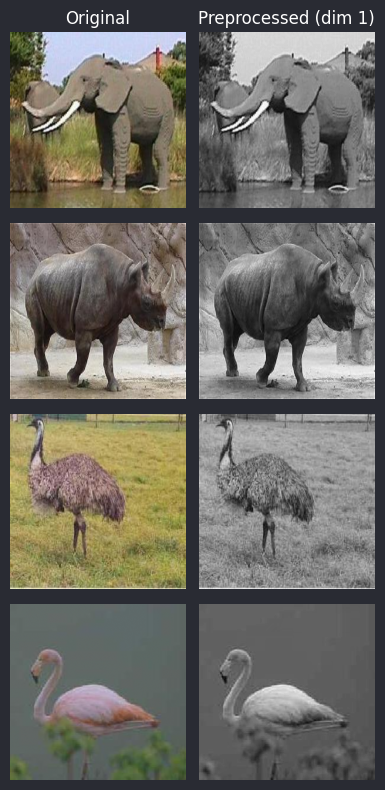

In [8]:
plot_animals(animals, pre, figsize=(4,8))

##### Salida

In [9]:
outputs = labels
print("Outputs -->", outputs.shape)

Outputs --> (243,)


#### Entrenamiento

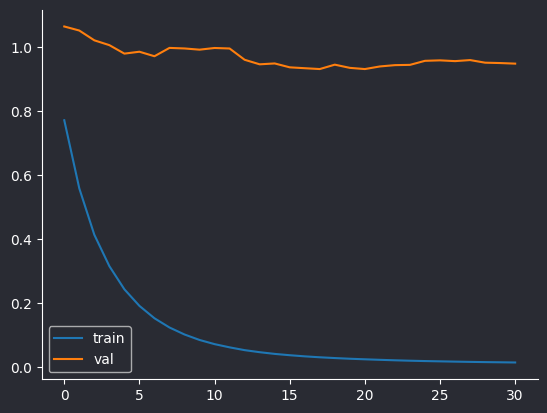

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = splitter(pre, outputs, SEED)

model = XGBModel()
cycles, duration = model.train(X_train, y_train, X_val, y_val)

summary['baseline'] = dict()
summary['baseline']['cycles'] = cycles
summary['baseline']['duration'] = duration

#### Resultado

### TABLA CON MÉTRICAS POR CLASE (accuracy total: 0.48)


precision  recall    f1
elephant        0.4    0.29  0.33
rhino           0.2    0.17  0.18
other           0.6    0.75  0.67
mean            0.4    0.40  0.39


### MATRIZ DE CONFUSIÓN


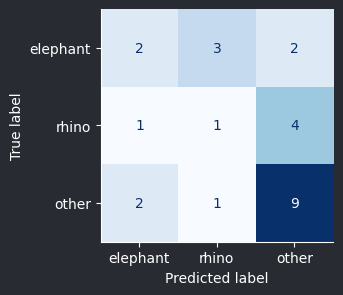

In [11]:
prediction = model.predict(X_test)
metrics = get_metrics(y_test, prediction, labels=[0, 1, 2], labels_names=['elephant', 'rhino', 'other'])
summary['baseline']['metrics'] = metrics

### <center>**---> APROACH 1 <---**</center>

#### Preprocesado

Imágenes en escala de gris, sin fondo y aplanadas

##### Entrada

In [12]:
animals_grayscale = rgb2gray(animals)
pre = (animals_grayscale*masks).reshape(243, -1)
print("Preprocessed Inputs -->", pre.shape)

Preprocessed Inputs --> (243, 90000)


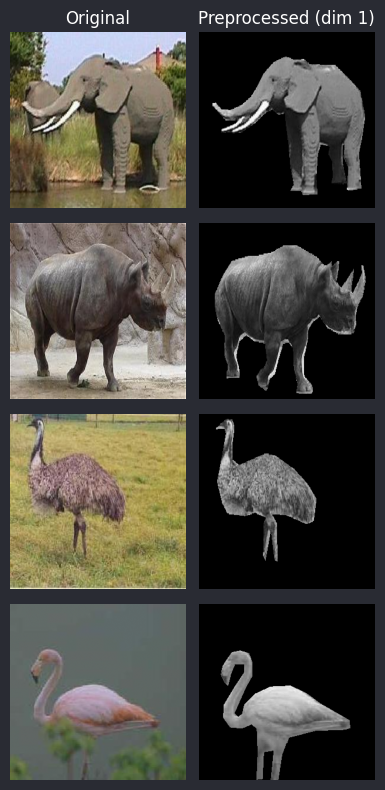

In [13]:
plot_animals(animals, pre, figsize=(4,8))

##### Salida

In [14]:
outputs = labels
print("Outputs -->", outputs.shape)

Outputs --> (243,)


#### Entrenamiento

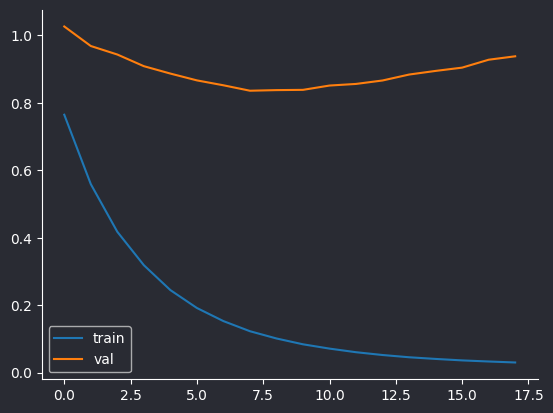

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = splitter(pre, outputs, SEED)

model = XGBModel()
cycles, duration = model.train(X_train, y_train, X_val, y_val)

summary['aproach_1 (grayscale + mask)'] = dict()
summary['aproach_1 (grayscale + mask)']['cycles'] = cycles
summary['aproach_1 (grayscale + mask)']['duration'] = duration

#### Resultado

### TABLA CON MÉTRICAS POR CLASE (accuracy total: 0.76)


precision  recall    f1
elephant       0.71    0.71  0.71
rhino          0.80    0.67  0.73
other          0.77    0.83  0.80
mean           0.76    0.74  0.75


### MATRIZ DE CONFUSIÓN


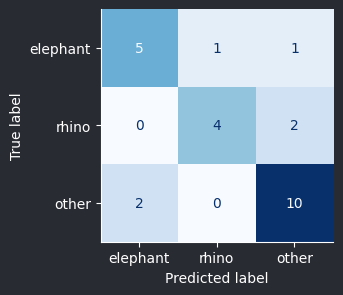

In [16]:
prediction = model.predict(X_test)
metrics = get_metrics(y_test, prediction, labels=[0, 1, 2], labels_names=['elephant', 'rhino', 'other'])
summary['aproach_1 (grayscale + mask)']['metrics'] = metrics

### <center>**---> APROACH 2 <---**</center>

#### Preprocesado

Imágenes en RGB, sin fondo y aplanadas

##### Entrada

In [17]:
pre = (animals*masks[:,:,:,np.newaxis]).reshape(243, -1)
print("Preprocessed Inputs -->", pre.shape)

Preprocessed Inputs --> (243, 270000)


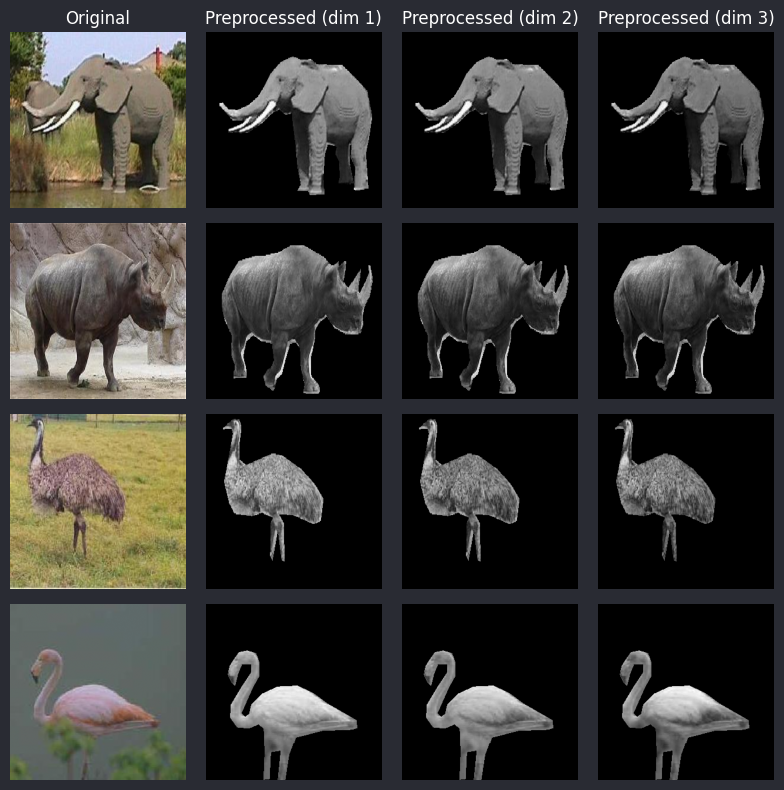

In [18]:
plot_animals(animals, pre)

##### Salida

In [19]:
outputs = labels
print("Outputs -->", outputs.shape)

Outputs --> (243,)


#### Entrenamiento

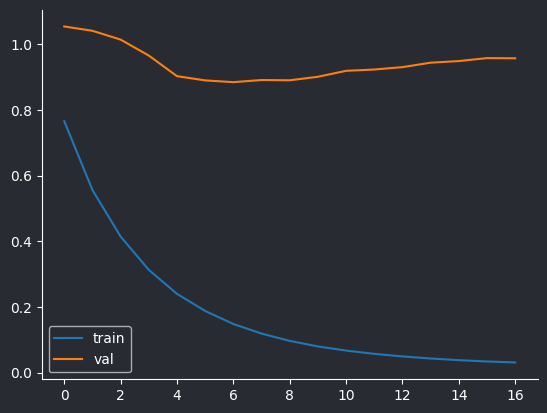

In [20]:
X_train, y_train, X_val, y_val, X_test, y_test = splitter(pre, outputs, SEED)

model = XGBModel()
cycles, duration = model.train(X_train, y_train, X_val, y_val)

summary['aproach_2 (RGB + mask)'] = dict()
summary['aproach_2 (RGB + mask)']['cycles'] = cycles
summary['aproach_2 (RGB + mask)']['duration'] = duration

#### Resultado

### TABLA CON MÉTRICAS POR CLASE (accuracy total: 0.56)


precision  recall    f1
elephant       0.50    0.29  0.36
rhino          0.50    0.50  0.50
other          0.60    0.75  0.67
mean           0.53    0.51  0.51


### MATRIZ DE CONFUSIÓN


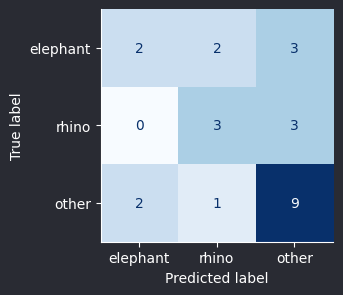

In [21]:
prediction = model.predict(X_test)
metrics = get_metrics(y_test, prediction, labels=[0, 1, 2], labels_names=['elephant', 'rhino', 'other'])
summary['aproach_2 (RGB + mask)']['metrics'] = metrics

### <center>**---> APROACH 3 <---**</center>

#### Preprocesado

Imágenes en escala de gris, sin fondo, marcando los bordes más importantes y aplanadas

##### Entrada

In [22]:
def intensify_edges(image):
    edges = feature.canny(image, sigma=4, low_threshold=0.01, high_threshold=0.1)
    image[edges] = 1
    return image

animals_grayscale = rgb2gray(animals)
masked_animals = animals_grayscale*masks
pre = np.array(list(map(lambda x: intensify_edges(x), masked_animals))).reshape(243,-1)
print("Preprocessed Inputs -->", pre.shape)

Preprocessed Inputs --> (243, 90000)


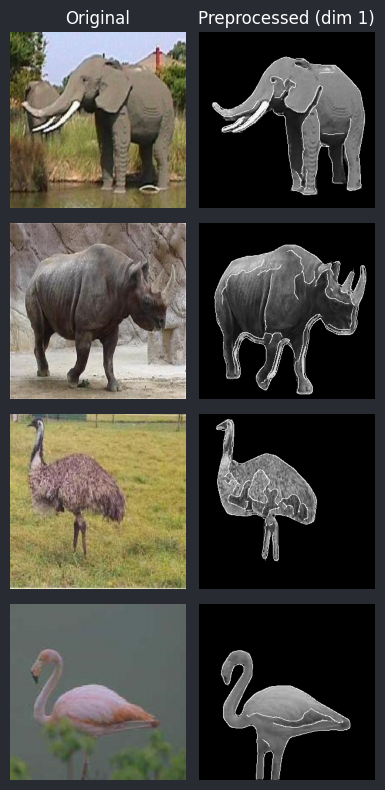

In [23]:
plot_animals(animals, pre, figsize=(4,8))

##### Salida

In [24]:
outputs = labels
print("Outputs -->", outputs.shape)

Outputs --> (243,)


#### Entrenamiento

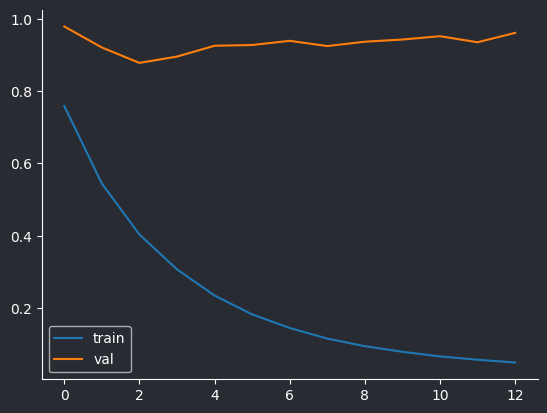

In [25]:
X_train, y_train, X_val, y_val, X_test, y_test = splitter(pre, outputs, SEED)

model = XGBModel()
cycles, duration = model.train(X_train, y_train, X_val, y_val)

summary['aproach_3 (grayscale + mask + Canny)'] = dict()
summary['aproach_3 (grayscale + mask + Canny)']['cycles'] = cycles
summary['aproach_3 (grayscale + mask + Canny)']['duration'] = duration

#### Resultado

### TABLA CON MÉTRICAS POR CLASE (accuracy total: 0.64)


precision  recall    f1
elephant       0.50    0.43  0.46
rhino          0.56    0.83  0.67
other          0.80    0.67  0.73
mean           0.62    0.64  0.62


### MATRIZ DE CONFUSIÓN


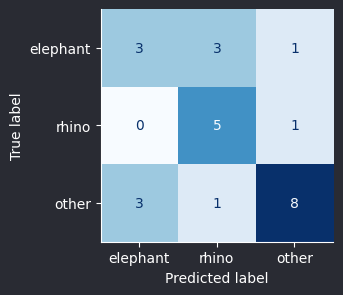

In [26]:
prediction = model.predict(X_test)
metrics = get_metrics(y_test, prediction, labels=[0, 1, 2], labels_names=['elephant', 'rhino', 'other'])
summary['aproach_3 (grayscale + mask + Canny)']['metrics'] = metrics

### <center>**---> APROACH 4 <---**</center>

#### Preprocesado

Imágenes en escala de gris, sin fondo, resaltando el 'esqueleto' y aplanadas

##### Entrada

In [27]:
def intensify_skeleton(image, mask):
    skeleton = morphology.skeletonize(mask)
    skeleton = morphology.dilation(skeleton, morphology.square(20))
    image[skeleton] = 1
    return image

animals_grayscale = rgb2gray(animals)
masked_animals = animals_grayscale*masks
pre = np.array(list(map(lambda x,y: intensify_skeleton(x,y), masked_animals, masks))).reshape(243,-1)
print("Preprocessed Inputs -->", pre.shape)

Preprocessed Inputs --> (243, 90000)


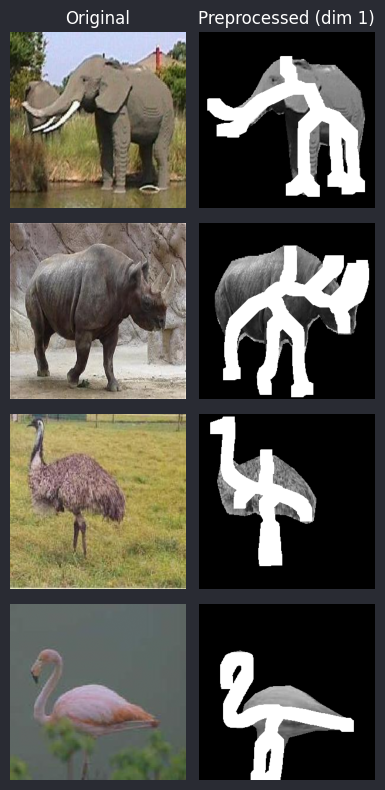

In [28]:
plot_animals(animals, pre, figsize=(4,8))

##### Salida

In [29]:
outputs = labels
print("Outputs -->", outputs.shape)

Outputs --> (243,)


#### Entrenamiento

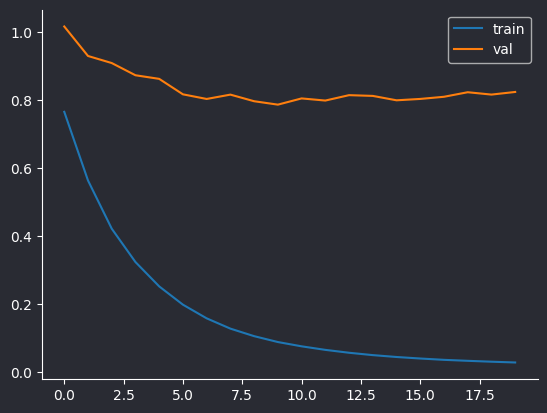

In [30]:
X_train, y_train, X_val, y_val, X_test, y_test = splitter(pre, outputs, SEED)

model = XGBModel()
cycles, duration = model.train(X_train, y_train, X_val, y_val)

summary['aproach_4 (grayscale + mask + skeleton)'] = dict()
summary['aproach_4 (grayscale + mask + skeleton)']['cycles'] = cycles
summary['aproach_4 (grayscale + mask + skeleton)']['duration'] = duration

#### Resultado

### TABLA CON MÉTRICAS POR CLASE (accuracy total: 0.72)


precision  recall    f1
elephant       1.00    0.43  0.60
rhino          0.71    0.83  0.77
other          0.67    0.83  0.74
mean           0.79    0.70  0.70


### MATRIZ DE CONFUSIÓN


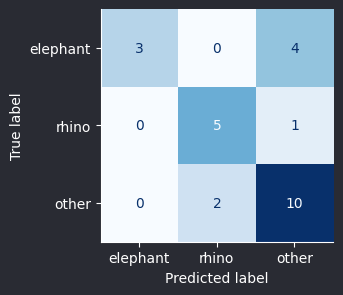

In [31]:
prediction = model.predict(X_test)
metrics = get_metrics(y_test, prediction, labels=[0, 1, 2], labels_names=['elephant', 'rhino', 'other'])
summary['aproach_4 (grayscale + mask + skeleton)']['metrics'] = metrics

### <center>**---> APROACH 5 <---**</center>

#### Preprocesado

Imágenes en escala de gris, sin fondo, utilizando cuatro umbrales de nivel de gris con Otsu y aplanadas

##### Entrada

In [32]:
def multi_thresholding(image):
    thresholds = threshold_multiotsu(image, 4)
    regions = np.digitize(image, bins=thresholds)
    return regions

animals_grayscale = rgb2gray(animals)
masked_animals = animals_grayscale*masks
pre = np.array(list(map(lambda x: multi_thresholding(x), masked_animals))).reshape(243,-1)
print("Preprocessed Inputs -->", pre.shape)

Preprocessed Inputs --> (243, 90000)


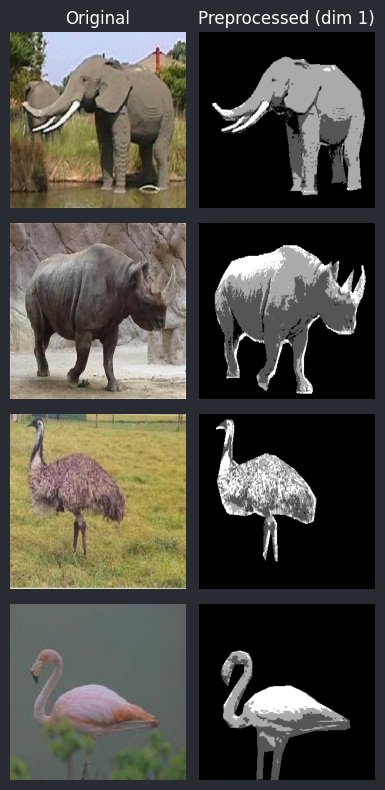

In [33]:
plot_animals(animals, pre, figsize=(4,8))

##### Salida

In [34]:
outputs = labels
print("Outputs -->", outputs.shape)

Outputs --> (243,)


#### Entrenamiento

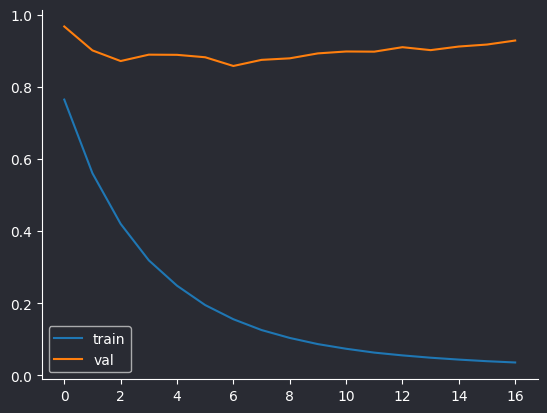

In [35]:
X_train, y_train, X_val, y_val, X_test, y_test = splitter(pre, outputs, SEED)

model = XGBModel()
cycles, duration = model.train(X_train, y_train, X_val, y_val)

summary['aproach_5 (grayscale + mask + otsu)'] = dict()
summary['aproach_5 (grayscale + mask + otsu)']['cycles'] = cycles
summary['aproach_5 (grayscale + mask + otsu)']['duration'] = duration

#### Resultado

### TABLA CON MÉTRICAS POR CLASE (accuracy total: 0.64)


precision  recall    f1
elephant       0.50    0.29  0.36
rhino          0.57    0.67  0.62
other          0.71    0.83  0.77
mean           0.60    0.60  0.58


### MATRIZ DE CONFUSIÓN


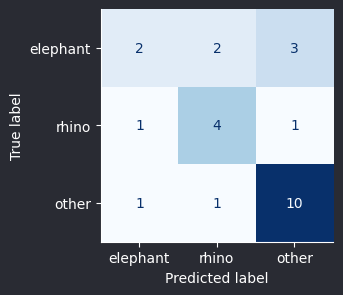

In [36]:
prediction = model.predict(X_test)
metrics = get_metrics(y_test, prediction, labels=[0, 1, 2], labels_names=['elephant', 'rhino', 'other'])
summary['aproach_5 (grayscale + mask + otsu)']['metrics'] = metrics

### <center>**---> COMBINATION <---**</center>

#### Preprocesado

- Escala de gris
- Escala de gris sin fondo
- Canales RGB sin fondo
- Bordes
- Esqueleto
- Multi Umbralización

##### Entrada

In [37]:
def intensify_edges(image):
    edges = feature.canny(image, sigma=4, low_threshold=0.01, high_threshold=0.1)
    zeros = np.zeros((300,300))
    zeros[edges] = 1
    return zeros

def intensify_skeleton(image, mask):
    skeleton = morphology.skeletonize(mask)
    skeleton = morphology.dilation(skeleton, morphology.square(20))
    zeros = np.zeros((300,300))
    zeros[skeleton] = 1
    return zeros

def multi_thresholding(image):
    thresholds = threshold_multiotsu(image, 4)
    regions = np.digitize(image, bins=thresholds)
    return regions

In [38]:
animals_grayscale = rgb2gray(animals)
masked_animals = animals_grayscale*masks

baseline = animals_grayscale.reshape(243, -1)
ap1 = (animals_grayscale*masks).reshape(243, -1)
ap21 = (animals*masks[:,:,:,np.newaxis])[:,:,:,0].reshape(243, -1)
ap22 = (animals*masks[:,:,:,np.newaxis])[:,:,:,1].reshape(243, -1)
ap23 = (animals*masks[:,:,:,np.newaxis])[:,:,:,2].reshape(243, -1)
ap3 = np.array(list(map(lambda x: intensify_edges(x), masked_animals))).reshape(243,-1)
ap4 = np.array(list(map(lambda x,y: intensify_skeleton(x,y), masked_animals, masks))).reshape(243,-1)
ap5 = np.array(list(map(lambda x: multi_thresholding(x), masked_animals))).reshape(243,-1)

In [39]:
pre = np.stack((baseline, ap1, ap21, ap22, ap23, ap3, ap4, ap5), axis=2).reshape(243,-1)
print("Preprocessed Inputs -->", pre.shape)

Preprocessed Inputs --> (243, 720000)


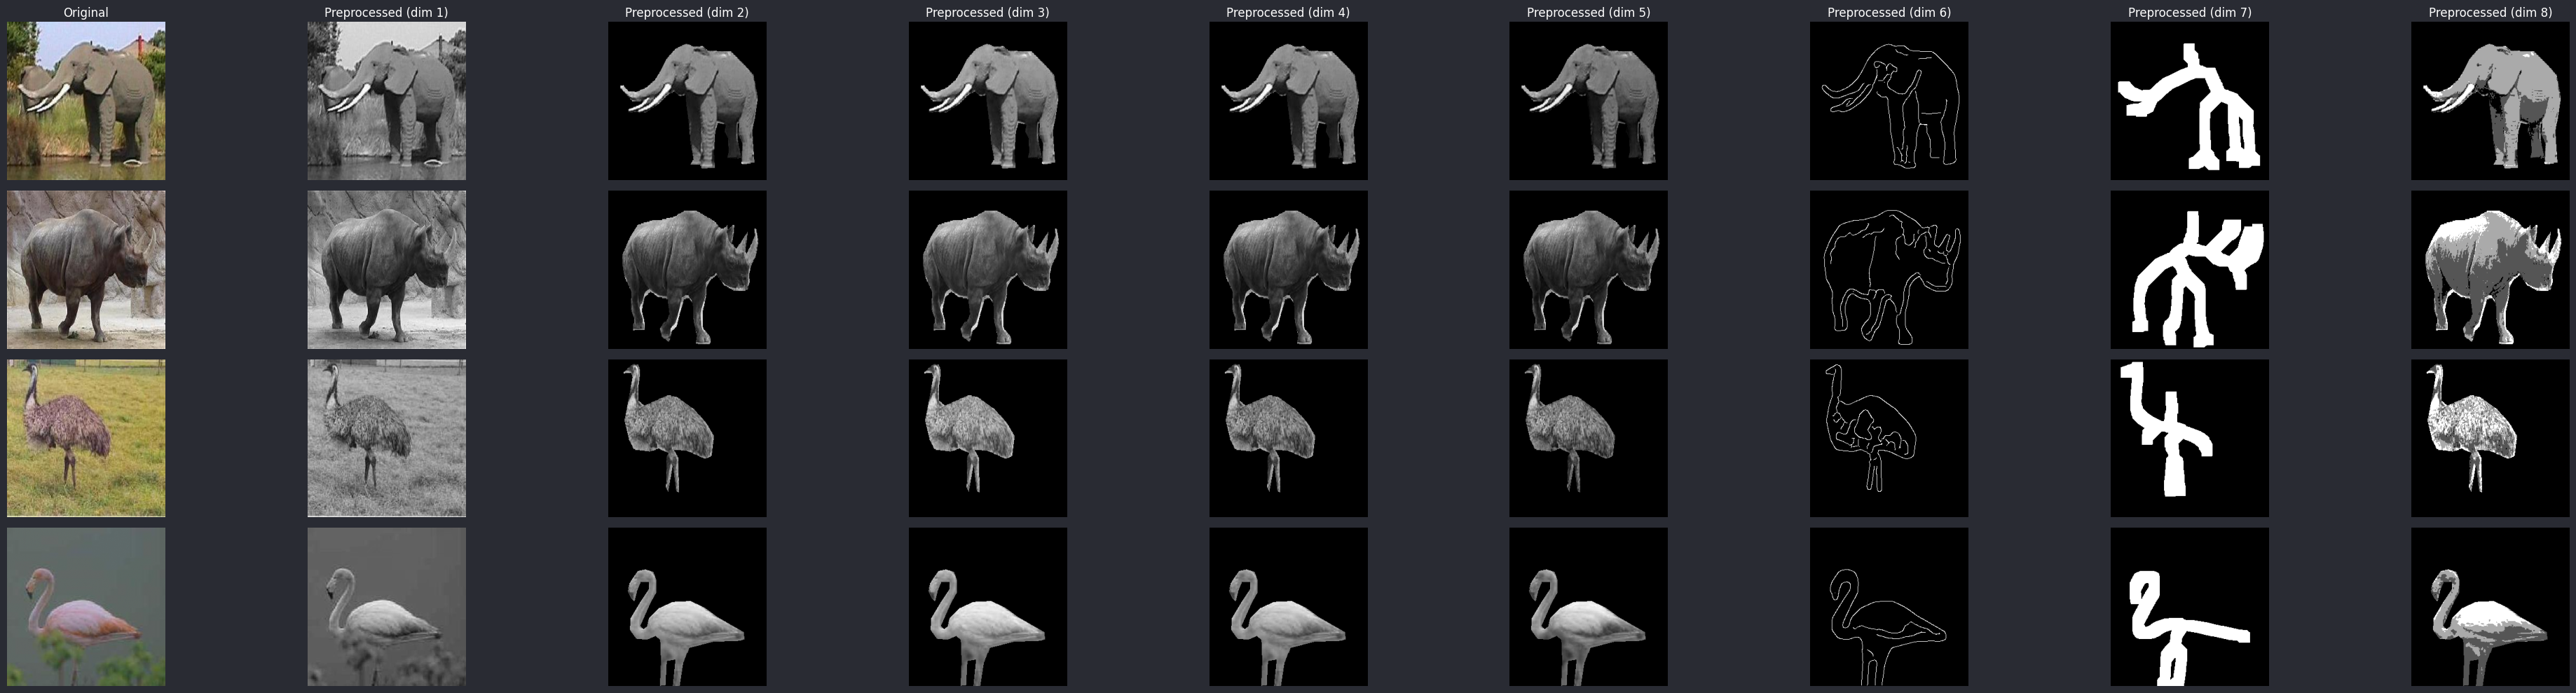

In [40]:
plot_animals(animals, pre, figsize=(40,10))

##### Salida

In [41]:
outputs = labels
print("Outputs -->", outputs.shape)

Outputs --> (243,)


#### Entrenamiento

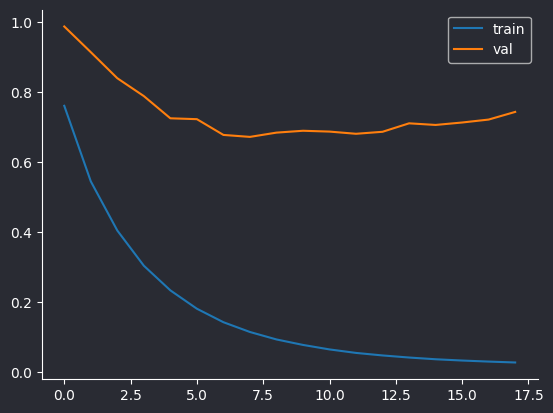

In [42]:
X_train, y_train, X_val, y_val, X_test, y_test = splitter(pre, outputs, SEED)

model = XGBModel()
cycles, duration = model.train(X_train, y_train, X_val, y_val)

summary['combination'] = dict()
summary['combination']['cycles'] = cycles
summary['combination']['duration'] = duration

#### Resultado

### TABLA CON MÉTRICAS POR CLASE (accuracy total: 0.6)


precision  recall    f1
elephant       0.50    0.29  0.36
rhino          0.43    0.50  0.46
other          0.71    0.83  0.77
mean           0.55    0.54  0.53


### MATRIZ DE CONFUSIÓN


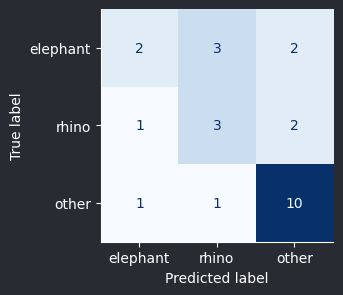

In [43]:
prediction = model.predict(X_test)
metrics = get_metrics(y_test, prediction, labels=[0, 1, 2], labels_names=['elephant', 'rhino', 'other'])
summary['combination']['metrics'] = metrics

### <center>**---> APROACH (?) <---**</center>

#### Preprocesado

Imágenes en escala de gris, extremandamente suavizadas con un filtro de medias (sigma=10), sin fondo y aplanadas

##### Entrada

In [44]:
animals_grayscale = rgb2gray(animals)
filtered_animals = ndi.gaussian_filter(animals_grayscale, sigma=10)
pre = (filtered_animals*masks).reshape(243, -1)
print("Preprocessed Inputs -->", pre.shape)

Preprocessed Inputs --> (243, 90000)


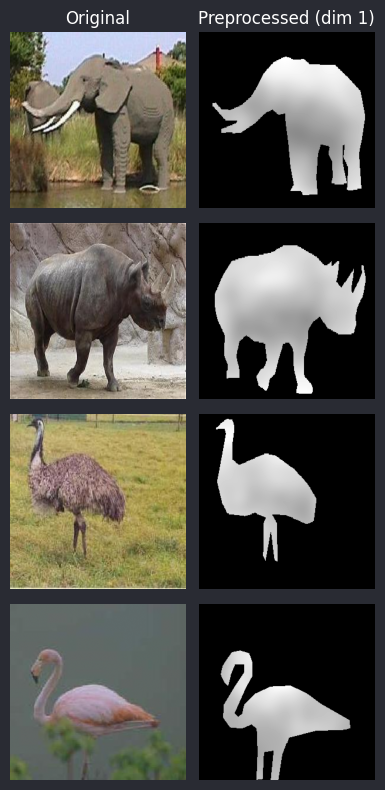

In [45]:
plot_animals(animals, pre, figsize=(4,8))

##### Salida

In [46]:
outputs = labels
print("Outputs -->", outputs.shape)

Outputs --> (243,)


#### Entrenamiento

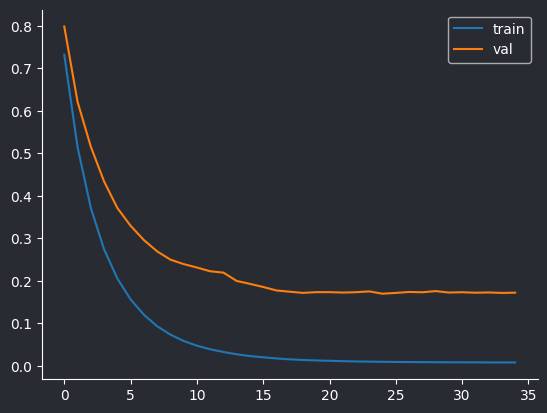

In [47]:
X_train, y_train, X_val, y_val, X_test, y_test = splitter(pre, outputs, 42)

model = XGBModel()
cycles, duration = model.train(X_train, y_train, X_val, y_val)

summary['aproach_(?)'] = dict()
summary['aproach_(?)']['cycles'] = cycles
summary['aproach_(?)']['duration'] = duration

#### Resultado

### TABLA CON MÉTRICAS POR CLASE (accuracy total: 1.0)


precision  recall   f1
elephant        1.0     1.0  1.0
rhino           1.0     1.0  1.0
other           1.0     1.0  1.0
mean            1.0     1.0  1.0


### MATRIZ DE CONFUSIÓN


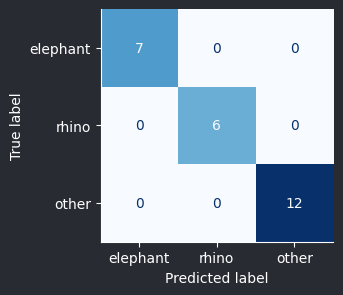

In [48]:
prediction = model.predict(X_test)
metrics = get_metrics(y_test, prediction, labels=[0, 1, 2], labels_names=['elephant', 'rhino', 'other'])
summary['aproach_(?)']['metrics'] = metrics

### <center>**---> SUMMARY <---**</center>

In [49]:
display(metrics_table(summary))

aproximación  ciclos  duración (s)  accuracy  \
0                                 baseline      31         36.24      0.48   
1             aproach_1 (grayscale + mask)      18         14.04      0.76   
2                   aproach_2 (RGB + mask)      17         39.65      0.56   
3     aproach_3 (grayscale + mask + Canny)      13         10.72      0.64   
4  aproach_4 (grayscale + mask + skeleton)      20         11.46      0.72   
5      aproach_5 (grayscale + mask + otsu)      17          6.10      0.64   
6                              combination      18        246.33      0.60   
7                              aproach_(?)      35         14.43      1.00   

   precision (mean)  recall (mean)  f1 (mean)  
0              0.40           0.40       0.39  
1              0.76           0.74       0.75  
2              0.53           0.51       0.51  
3              0.62           0.64       0.62  
4              0.79           0.70       0.70  
5              0.60           0.60       0.58  
6              0.55           0.54       0.53  
7              1.00           1.00       1.00

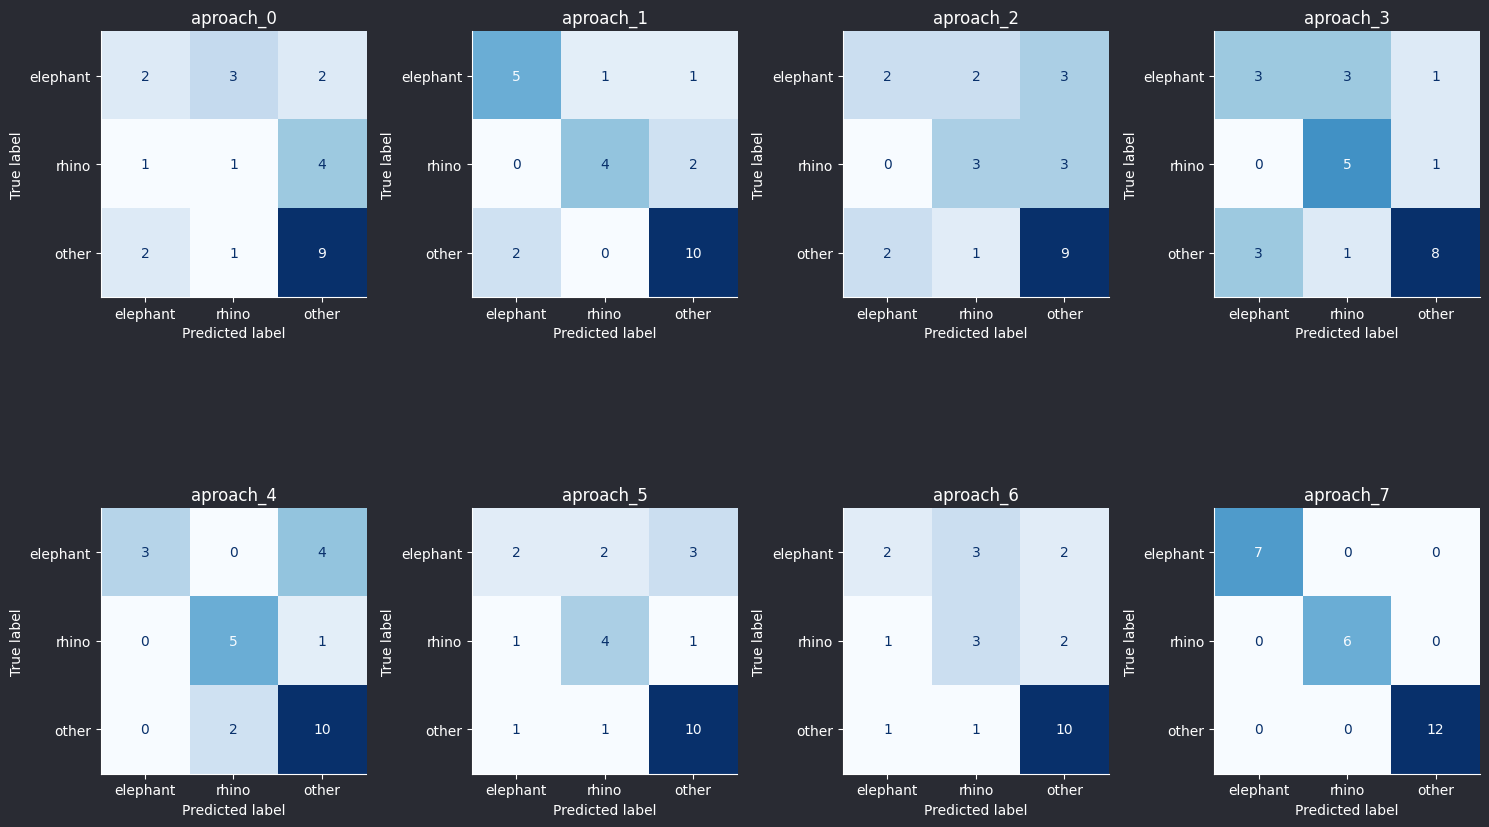

In [50]:
plot_all_cm(summary)